# Transfer Learning

So far, we have trained accurate models on large datasets, and also downloaded a pre-trained model that we used with no training necessary. But what if we cannot find a pre-trained model that does exactly what you need, and what if we do not have a sufficiently large dataset to train a model from scratch? In this case, there is a very helpful technique we can use called transfer learning.

With transfer learning, we take a pre-trained model and retrain it on a task that has some overlap with the original training task. A good analogy for this is an artist who is skilled in one medium, such as painting, who wants to learn to practice in another medium, such as charcoal drawing. We can imagine that the skills they learned while painting would be very valuable in learning how to draw with charcoal. 

As an example in deep learning, say we have a pre-trained model that is very good at recognizing different types of cars, and we want to train a model to recognize types of motorcycles. A lot of the learnings of the car model would likely be very useful, for instance the ability to recognize headlights and wheels. 

Transfer learning is especially powerful when we do not have a large and varied dataset. In this case, a model trained from scratch would likely memorize the training data quickly, but not be able to generalize well to new data. With transfer learning, you can increase your chances of training an accurate and robust model on a small dataset.

## Objectives

* Prepare a pretrained model for transfer learning
* Perform transfer learning with your own small dataset on a pretrained model
* Further fine tune the model for even better performance

## A Personalized Doggy Door

In this Notebook, we would like to create a doggy door that only lets in a particular dog. In this case, we will make an automatic doggy door for a dog named Bo, the United States First Dog between 2009 and 2017. There are more pictures of Bo in the `data/presidential_doggy_door` folder.

<img src="https://raw.githubusercontent.com/harmanani/AAI612/main/Week4/presidential_doggy_door/train/bo/bo_10.jpg">

The challenge is that the pre-trained model was not trained to recognize this specific dog, and, we only have 30 pictures of Bo. If we tried to train a model from scratch using those 30 pictures we would experience overfitting and poor generalization. However, if we start with a pre-trained model that is adept at detecting dogs, we can leverage that learning to gain a generalized understanding of Bo using our smaller dataset. We can use transfer learning to solve this challenge.

## Downloading the Pretrained Model

The [ImageNet pre-trained models](https://keras.io/api/applications/vgg/#vgg16-function) are often good choices for computer vision transfer learning, as they have learned to classify various different types of images. In doing this, they have learned to detect many different types of [features](https://developers.google.com/machine-learning/glossary#) that could be valuable in image recognition. Because ImageNet models have learned to detect animals, including dogs, it is especially well suited for this transfer learning task of detecting Bo.

Let us start by downloading the pre-trained model. Again, this is available directly from the Keras library. As we are downloading, there is going to be an important difference. The last layer of an ImageNet model is a [dense layer](https://developers.google.com/machine-learning/glossary#dense-layer) of 1000 units, representing the 1000 possible classes in the dataset. In our case, we want it to make a different classification: is this Bo or not? Because we want the classification to be different, we are going to remove the last layer of the model. We can do this by setting the flag `include_top=False` when downloading the model. After removing this top layer, we can add new layers that will yield the type of classification that we want:

In [1]:
from tensorflow import keras

base_model = keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 238s 4us/step


In [2]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

## Freezing the Base Model
Before we add our new layers onto the [pre-trained model](https://developers.google.com/machine-learning/glossary#pre-trained-model), we should take an important step: freezing the model's pre-trained layers. This means that when we train, we will not update the base layers from the pre-trained model. Instead we will only update the new layers that we add on the end for our new classification. We freeze the initial layers because we want to retain the learning achieved from training on the ImageNet dataset. If they were unfrozen at this stage, we would likely destroy this valuable information. There will be an option to unfreeze and train these layers later, in a process called fine-tuning.

Freezing the base layers is as simple as setting trainable on the model to `False`.

In [3]:
base_model.trainable = False

## Adding New Layers

We can now add the new trainable layers to the pre-trained model. They will take the features from the pre-trained layers and turn them into predictions on the new dataset. We will add two layers to the model. First will be a pooling layer like we saw in our earlier [convolutional neural network](https://developers.google.com/machine-learning/glossary#convolutional_layer). (If you want a more thorough understanding of the role of pooling layers in CNNs, please read [this detailed blog post](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/#:~:text=A%20pooling%20layer%20is%20a,Convolutional%20Layer)). We then need to add our final layer, which will classify Bo or not Bo. This will be a densely connected layer with one output.

In [4]:
inputs = keras.Input(shape=(224, 224, 3))
# Separately from setting trainable on the model, we set training to False 
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

Let us take a look at the model, now that we have combined the pre-trained model with the new layers.

In [5]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,715,201 (56.13 MB)

 Trainable params: 513 (2.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Keras gives us a nice summary here, as it shows the vgg16 pre-trained model as one unit, rather than showing all of the internal layers. It is also worth noting that we have many non-trainable parameters as we have frozen the pre-trained model. 

## Compiling the Model

As with our previous exercises, we need to compile the model with loss and metrics options. We have to make some different choices here. In previous cases we had many categories in our classification problem. As a result, we picked categorical crossentropy for the calculation of our loss. In this case we only have a binary classification problem (Bo or not Bo), and so we will use [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy). Further detail about the differences between the two can found [here](https://gombru.github.io/2018/05/23/cross_entropy_loss/). We will also use binary accuracy instead of traditional accuracy.

By setting `from_logits=True` we inform the [loss function](https://gombru.github.io/2018/05/23/cross_entropy_loss/) that the output values are not normalized (e.g. with softmax).

In [6]:
# Important to use binary crossentropy and binary accuracy as we now have a binary classification problem
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True), metrics=[keras.metrics.BinaryAccuracy()])

## Augmenting the Data

Now that we are dealing with a very small dataset, it is especially important that we augment our data. As before, we will make small modifications to the existing images, which will allow the model to see a wider variety of images to learn from. This will help it learn to recognize new pictures of Bo instead of just memorizing the pictures it trains on.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create a data generator
datagen = ImageDataGenerator(
        samplewise_center=True,  # set each sample mean to 0
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False) # we don't expect Bo to be upside-down so we will not flip vertically

## Loading the Data

We have seen datasets in a couple different formats so far. In the MNIST exercise, we were able to download the dataset directly from within the Keras library. For the sign language dataset, the data was in CSV files. For this exercise, we are going to load images directly from folders using Keras' [`flow_from_directory`](https://keras.io/api/preprocessing/image/) function. We have set up our directories to help this process go smoothly as our labels are inferred from the folder names. In the `data/presidential_doggy_door` directory, we have train and validation directories, which each have folders for images of Bo and not Bo. In the not_bo directories, we have pictures of other dogs and cats, to teach our model to keep out other pets. Feel free to explore the images to get a sense of our dataset.

Note that [flow_from_directory](https://keras.io/api/preprocessing/image/) will also allow us to size our images to match the model: 244x244 pixels with 3 channels.

In [9]:
# load and iterate training dataset
train_it = datagen.flow_from_directory('presidential_doggy_door/train/', 
                                       target_size=(224, 224), 
                                       color_mode='rgb', 
                                       class_mode='binary', 
                                       batch_size=8)
# load and iterate validation dataset
valid_it = datagen.flow_from_directory('presidential_doggy_door/valid/', 
                                      target_size=(224, 224), 
                                      color_mode='rgb', 
                                      class_mode='binary', 
                                      batch_size=8)

Found 139 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


## Training the Model

Time to train our model and see how it does. Recall that when using a data generator, we have to explicitly set the number of `steps_per_epoch`:

In [10]:
model.fit(train_it, steps_per_epoch=12, validation_data=valid_it, validation_steps=4, epochs=20)

C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - binary_accuracy: 0.6074 - loss: 2.3093 - val_binary_accuracy: 0.8000 - val_loss: 1.5253
Epoch 2/20
 6/12 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - binary_accuracy: 0.7951 - loss: 0.7058

C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - binary_accuracy: 0.7413 - loss: 0.9850 - val_binary_accuracy: 0.7333 - val_loss: 0.9414
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - binary_accuracy: 0.8041 - loss: 0.3666 - val_binary_accuracy: 0.8667 - val_loss: 0.9726
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - binary_accuracy: 0.8877 - loss: 0.2638 - val_binary_accuracy: 0.8000 - val_loss: 0.8325
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - binary_accuracy: 0.8803 - loss: 0.3466 - val_binary_accuracy: 0.9000 - val_loss: 0.6143
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - binary_accuracy: 0.8944 - loss: 0.2106 - val_binary_accuracy: 0.8667 - val_loss: 0.6489
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - binary_accuracy: 0.9831 - loss: 0.0621 - val_binary_accuracy: 0.8667 - val_loss: 0.5478
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - binary_accuracy: 0.9399 - loss: 0.2719 - val_binary_accuracy: 0.8667 - val_loss: 0.4256
Epoch 9/20
12/12 ━━━━━━━━━━━━━━

## Discussion of Results

Both the training and validation accuracy should be quite high. This is a pretty awesome result! We were able to train on a small dataset, but because of the knowledge transferred from the ImageNet model, it was able to achieve high accuracy and generalize well. This means it has a very good sense of Bo and pets who are not Bo.

If you saw some fluctuation in the validation accuracy, that is okay too. We have a technique for improving our model in the next section.

## Fine-Tuning the Model

Now that the new layers of the model are trained, we have the option to apply a final trick to improve the model, called [fine-tuning](https://developers.google.com/machine-learning/glossary#f). To do this we unfreeze the entire model, and train it again with a very small [learning rate](https://developers.google.com/machine-learning/glossary#learning-rate). This will cause the base pre-trained layers to take very small steps and adjust slightly, improving the model by a small amount.  

Note that it is important to only do this step after the model with frozen layers has been fully trained. The untrained pooling and classification layers that we added to the model earlier were randomly initialized. This means they needed to be updated quite a lot to correctly classify the images. Through the process of [backpropagation](https://developers.google.com/machine-learning/glossary#backpropagation), large initial updates in the last layers would have caused potentially large updates in the pre-trained layers as well. These updates would have destroyed those important pre-trained features. However, now that those final layers are trained and have converged, any updates to the model as a whole will be much smaller (especially with a very small learning rate) and will not destroy the features of the earlier layers.

Let's try unfreezing the pre-trained layers, and then fine tuning the model:

In [11]:
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are taken into account
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = .00001),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [12]:
model.fit(train_it, steps_per_epoch=12, validation_data=valid_it, validation_steps=4, epochs=10)

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 141s 12s/step - binary_accuracy: 0.9503 - loss: 0.2091 - val_binary_accuracy: 0.9667 - val_loss: 0.1231
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 76s 6s/step - binary_accuracy: 1.0000 - loss: 0.0019 - val_binary_accuracy: 0.9667 - val_loss: 0.2579
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 144s 12s/step - binary_accuracy: 0.9965 - loss: 0.0082 - val_binary_accuracy: 0.8667 - val_loss: 0.3577
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 86s 7s/step - binary_accuracy: 0.9832 - loss: 0.0475 - val_binary_accuracy: 1.0000 - val_loss: 0.0025
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 162s 13s/step - binary_accuracy: 1.0000 - loss: 0.0040 - val_binary_accuracy: 1.0000 - val_loss: 0.0017
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 78s 6s/step - binary_accuracy: 1.0000 - loss: 0.0012 - val_binary_accuracy: 1.0000 - val_loss: 0.0085
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 129s 11s/step - binary_accuracy: 1.0000 - loss: 8.4009e-05 - val_binary_accuracy: 1.0000 - val_loss: 0.0056
Epoch 8/

## Examining the Predictions

Now that we have a well-trained model, it is time to create our doggy door for Bo! We can start by looking at the predictions that come from the model. We will preprocess the image in the same way we did for our last doggy door.

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

def make_predictions(image_path):
    show_image(image_path)
    image = image_utils.load_img(image_path, target_size=(224, 224))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,224,224,3)
    image = preprocess_input(image)
    preds = model.predict(image)
    return preds

Try this out on a couple images to see the predictions:

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[-9.881925]], dtype=float32)

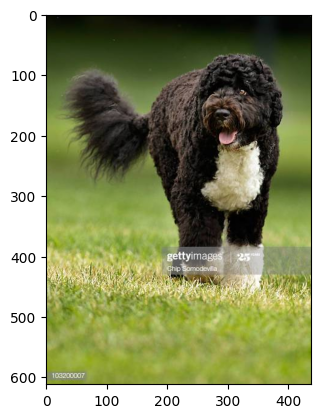

In [14]:
make_predictions('presidential_doggy_door/valid/bo/bo_20.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[22.062054]], dtype=float32)

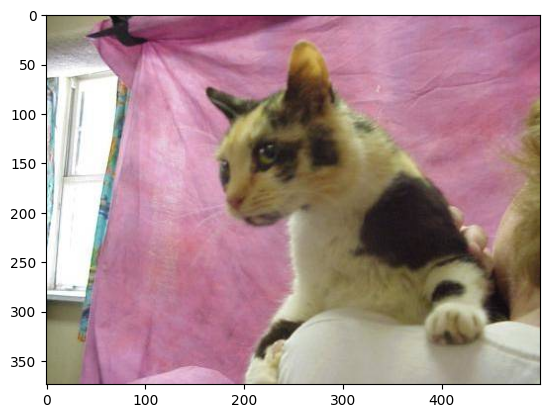

In [15]:
make_predictions('presidential_doggy_door/valid/not_bo/121.jpg')

It looks like a negative number prediction means that it is Bo and a positive number prediction means it is something else. We can use this information to have our doggy door only let Bo in! 

## Exercise: Bo's Doggy Door

Fill in the following code to implement Bo's doggy door:

In [16]:
def presidential_doggy_door(image_path):
    preds = make_predictions(image_path)
    if preds[0] < 0:
        print("It's Bo! Let him in!")
    else:
        print("That's not Bo! Stay out!")

Let's try it out!

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
That's not Bo! Stay out!


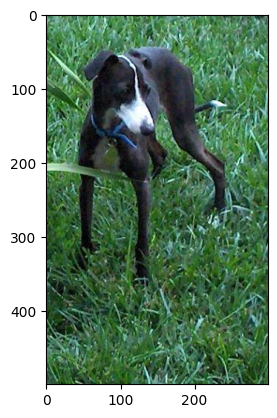

In [17]:
presidential_doggy_door('presidential_doggy_door/valid/not_bo/131.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
It's Bo! Let him in!


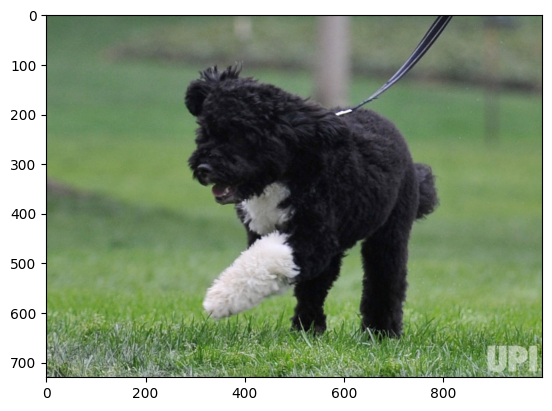

In [18]:
presidential_doggy_door('presidential_doggy_door/valid/bo/bo_29.jpg')

## Summary

So far, we have looked at image classification. In the next week, we are going to switch gears and address working with sequential data, which requires a different approach.